In [15]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import cyecca.lie as lie
import casadi as ca
from scipy.integrate import solve_ivp

In [16]:
cos = sp.cos
sin = sp.sin

In [17]:
p_x, p_y, p_z = sp.symbols(r"p_x p_y p_z")
v_x, v_y, v_z = sp.symbols(r"v_x v_y v_z")
# yaw pitch roll sequence
psi, theta, phi = sp.symbols(r"psi theta phi")
omega1, omega2, omega3 = sp.symbols(r"omega_1 omega_2 omega_3")
a_x, a_y, a_z = sp.symbols(r"a_x a_y a_z")
g = sp.Matrix([0,0,-9.81])
e1 = sp.Matrix([1,0,0])

p = sp.Matrix([p_x, p_y, p_z])
v = sp.Matrix([v_x, v_y, v_z])
angle = sp.Matrix([psi, theta, phi])
x = sp.Matrix([p,v,angle])
omega = sp.Matrix([omega1, omega2, omega3])
a = sp.Matrix([a_x, a_y, a_z])
# u = sp.Matrix([[a],[omega]])
skew_omega = sp.Matrix([[0, -omega3, omega2],
                 [omega3, 0, -omega1],
                 [-omega2, omega1, 0]])

R = sp.Matrix([[cos(theta)*cos(psi), sin(phi)*sin(theta)*cos(psi) - cos(phi)*sin(psi), cos(phi)*sin(theta)*cos(psi) + sin(phi)*sin(psi)],
               [cos(theta)*sin(psi), sin(phi)*sin(theta)*sin(psi) + cos(phi)*cos(psi), cos(phi)*sin(theta)*sin(psi) - sin(phi)*cos(psi)],
               [-sin(theta), sin(phi)*cos(theta), cos(phi)*cos(theta) ]
               ])


f = sp.Matrix([v,
              R@a+g,
              R@skew_omega@e1])
x


Matrix([
[  p_x],
[  p_y],
[  p_z],
[  v_x],
[  v_y],
[  v_z],
[  psi],
[theta],
[  phi]])

In [32]:

lam_f = sp.lambdify([x,a, omega], f[:])

def simulate_sympy(time, x0, acc, ang_vel):
    def dynamics(t,x):
        res = lam_f(x, acc, ang_vel)
        return res

    t_span = (time[0], time[-1])
    res_sympy = solve_ivp(
                    fun=lambda t,y: dynamics(t,y),
                    t_span=t_span,
                    y0=x0,
                    t_eval=time,
                )
    return res_sympy['y'].T




In [19]:
# def controls(t):
#     a_thrust = acc
#     omega = ang_acc
    
#     return np.concatenate([a_thrust, omega])
# res_euler = simulate_euler_ref(drone, time, x0, controls)

In [20]:
# # print(res_sympy['y'].T.shape)
# # print(res_euler.shape)
# plot_states(time, [res_sympy['y'].T], names=["sp", "euler"])

In [21]:
class Quadrotor:
    def __init__(self):
        # gravity near earth.
        self.g = np.array([0, 0, -9.81])

    def ref_dynamics_euler(self, t, state, controls, disturbance=None):
        p, v, phi = state[0:3], state[3:6], state[6:9]

        u = controls(t) if callable(controls) else controls
        a, omega = u[0:3], u[3:6]


        d = disturbance(t) if disturbance else 0

        # Rotation matrix from quaternion
        phi_lie = lie.SO3EulerB321.elem(ca.DM(phi))
        R = np.array(ca.DM(lie.SO3Dcm.from_Euler(phi_lie).param).full()).reshape(3, 3)

        # Dynamics
        p_dot = v
        v_dot = R @ a + self.g + d

        # Put rotation in quaternion to avoid singularity
        omega_quat = lie.SO3Quat.elem(ca.DM([0, *omega]))
        phi_quat = lie.SO3Quat.from_Euler(phi_lie)
        q_dot = phi_quat * omega_quat
        phi_dot = np.array(ca.DM(lie.SO3EulerB321.from_Quat(q_dot).param).full()).flatten()

        return np.concatenate([p_dot, v_dot, phi_dot])

    def ref_dynamics_quat(self, t, state, controls, disturbance=None):
        p, v, q = state[0:3], state[3:6], state[6:10]
        q = q / np.linalg.norm(q)

        u = controls(t) if callable(controls) else controls
        a, omega = u[0:3], u[3:6]


        d = disturbance(t) if disturbance else  0

        # Rotation matrix from quaternion
        q_lie = lie.SO3Quat.elem(ca.DM(q))
        R = np.array(ca.DM(lie.SO3Dcm.from_Quat(q_lie).param).full()).reshape(3, 3)

        # Dynamics
        p_dot = v
        v_dot = R @ a + self.g + d

        # Quaternion kinematics
        omega_quat = lie.SO3Quat.elem(ca.DM([0, *omega]))
        q_dot = np.array(ca.DM((q_lie * omega_quat).param).full()).flatten() / 2

        return np.concatenate([p_dot, v_dot, q_dot])
    
    def cl_dynamics(self, t, state, controls, ref_traj, gain_matrix, disturbance=None):
        p, v, q = state[0:3], state[3:6], state[6:10]
        q = q / np.linalg.norm(q)

        u = controls(t) if callable(controls) else controls
        a, omega = u[0:3], u[3:6]

        A = np.array([[0,1,0],
                      [0,0,a],
                      [0,0,omega_quat]])
        d = disturbance(t)

        # Rotation matrix from quaternion
        q_lie = lie.SO3Quat.elem(ca.DM(q))
        R = np.array(ca.DM(lie.SO3Dcm.from_Quat(q_lie).param).full()).reshape(3, 3)

        # Dynamics
        p_dot = v
        v_dot = R @ a + self.g + d

        # Quaternion kinematics
        omega_quat = lie.SO3Quat.elem(ca.DM([0, *omega]))
        q_dot = np.array(ca.DM((q_lie * omega_quat).param).full()).flatten() / 2

        return np.concatenate([p_dot, v_dot, q_dot])

In [22]:
def simulate_quat_ref(spacecraft, t_span, state_0, controls,
                        rtol=1e-9, atol=1e-12):
    sol = solve_ivp(
        lambda t, x: spacecraft.ref_dynamics_quat(t, x, controls),
        (t_span[0], t_span[-1]), state_0,
        dense_output=True, rtol=rtol, atol=atol
    )
    return np.array([sol.sol(t) for t in t_span])

def simulate_euler_ref(spacecraft, t_span, state_0, controls,
                       rtol=1e-9, atol=1e-12):
    sol = solve_ivp(
        lambda t, x: spacecraft.ref_dynamics_euler(t, x, controls),
        (t_span[0], t_span[-1]), state_0,
        dense_output=True, rtol=rtol, atol=atol
    )
    return np.array([sol.sol(t) for t in t_span])


In [23]:
drone = Quadrotor()
t_span = np.linspace(0, 50, 500)

# Initial conditions: hover at 10m
x0_quat = np.array([0, 0, 10, 0, 0, 0, 1, 0, 0, 0])
x0_euler = np.array([0, 0, 10, 0, 0, 0, 0, 0, 0])

def controls(t):

    a_thrust = np.array([0, 0, 10.0]) 
    omega = np.array([0,0,0])
    
    return np.concatenate([a_thrust, omega])


In [ ]:
res_quat = simulate_quat_ref(drone, t_span, x0_quat, controls)
res_euler = simulate_euler_ref(drone, t_span, x0_euler, controls)
res_quat2 = np.zeros((res_quat.shape[0], 9))
res_quat2[:, 0:6] = res_quat[:, 0:6]
for i,itm in enumerate(res_quat):
    q = itm[6:10]
    q = q / np.linalg.norm(q)
    q_lie = lie.SO3Quat.elem(ca.DM(q))
    phi = lie.SO3EulerB321.from_Quat(q_lie).param
    phi = ca.DM(phi).full()
    res_quat2[i,6:9] =  phi.flatten()

In [25]:
def plot_states(t_span, data_list, names):
    fig, ax = plt.subplots(3, 1, figsize=(10,8))
    for i,data in enumerate(data_list):
        ax[0].plot(t_span, data[:, 0], label=f'$p_x$ {names[i]}')
        ax[0].plot(t_span, data[:, 1], label=r'$p_y$')
        ax[0].plot(t_span, data[:, 2], label=r'$p_z$')
        ax[0].legend()

        ax[1].plot(t_span, data[:, 3], label=r'$v_x$')
        ax[1].plot(t_span, data[:, 4], label=r'$v_y$')
        ax[1].plot(t_span, data[:, 5], label=r'$v_z$')
        ax[1].legend()

        ax[2].plot(t_span, data[:, 6], label=r'yaw')
        ax[2].plot(t_span, data[:, 7], label=r'pitch')
        ax[2].plot(t_span, data[:, 8], label=r'roll')
        ax[2].legend()

    
    plt.plot()

# def plot_many(t_span, data_list):
#     for data in data_list:
#         plot_states(t_span, data)

# plot_states(t_span, [res_quat2, res_euler], ["quat","euler"])

In [37]:
acc = np.array([0, 0, 10.0]) 
ang_vel = np.array([0.1,0,0])
dt=0.1
tf = 50
x0 = np.array([0,0,10,0,0,0,0,0,0])
x0_quat = np.array([0, 0, 10, 0, 0, 0, 1, 0, 0, 0])
time = np.arange(0,tf, dt)
def controls(t):
    return np.concatenate([acc, ang_vel])

res_sympy = simulate_sympy(time, x0, acc, ang_vel)

res_quat = simulate_quat_ref(drone, time, x0_quat, controls)
# res_euler = simulate_euler_ref(drone, time, x0, controls)

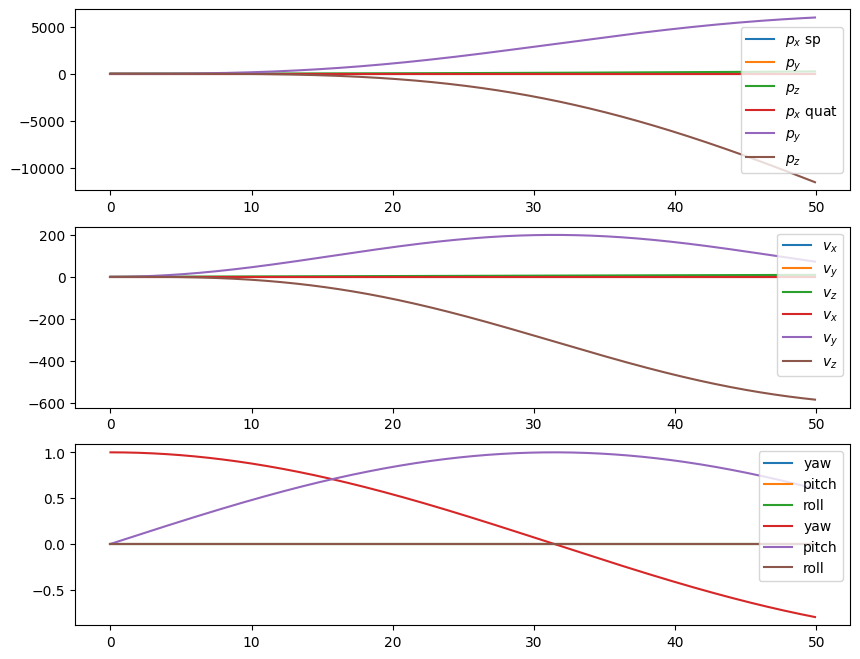

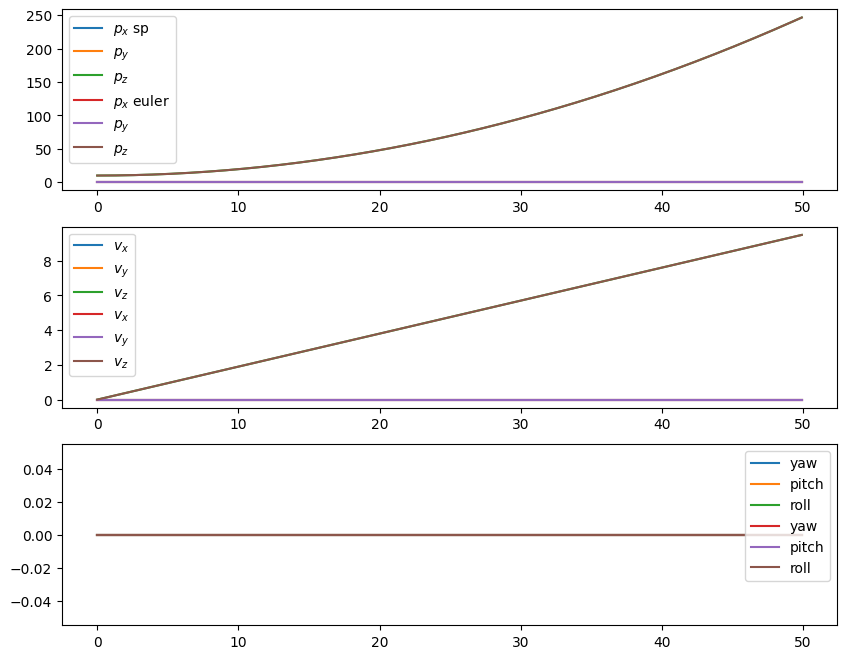

In [38]:
plot_states(time, [res_sympy, res_quat], names=["sp", "quat"])
plot_states(time, [res_sympy, res_euler], names=["sp", "euler"])

In [27]:
x0_quat = np.array([0, 0, 10, 0, 0, 0, 1, 0, 0, 0])
x0_euler = np.array([0, 0, 10, 0, 0, 0, 0, 0, 0])


    
    


In [28]:
q = [1.0, 0.0, 0.0, 0.0] 
q = q / np.linalg.norm(q)

# Rotation matrix from quaternion
q_lie = lie.SO3Quat.elem(ca.DM(q))
R = np.array(ca.DM(lie.SO3Dcm.from_Quat(q_lie).param).full()).reshape(3, 3)
phi = lie.SO3EulerB321.from_Quat(q_lie).param
ca.DM(phi).full()

x0_euler = np.array([0, 0, 10, 0, 0, 0, 0, 0, 0])

def controls(t):

    a_thrust = np.array([0, 0, 10.0]) 
    omega = np.array([0,0,0])
    
    return np.concatenate([a_thrust, omega])